# Cours #5: Différentiation numérique

In [ ]:
def difference_finie_avant(x:np.ndarray, f: Callable):
    return

In [ ]:
def difference_finie_arriere(x:np.ndarray, f: Callable):
    return

In [ ]:
def difference_finie_centree(x:np.ndarray, f: Callable):
    return

In [ ]:
def difference_finie_seconde_centree(x:np.ndarray, f: Callable):
    return

In [18]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.signal import butter, filtfilt
from scipy.interpolate import UnivariateSpline

Import des données de la montre durant un entraînement de course.

In [19]:
# Charger les données
dataset = pd.read_csv("interval_training_data.csv")
longitude = np.array(dataset["_lon"]) * 2*np.pi/360
latitude = np.array(dataset["_lat"]) * 2*np.pi/360
elevation_montre = np.array(dataset["ele"])
timestamps = np.array(dataset["time"])

# Convertir les timestamps en secondes
temps = np.array([datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ').timestamp() for time in timestamps])
temps = temps - temps[0]

# Convertir les coordonnées en mètres
R = 6367281 + np.mean(elevation_montre)  # Rayon de la Terre à Montréal en mètres

position_x = R * np.cos(latitude)
position_y = R * np.cos(longitude)
position_x = position_x - position_x[0]
position_y = position_y - position_y[0]
distance_parcourue = np.linalg.norm(np.array([position_x[1:] - position_x[:-1], position_y[1:] - position_y[:-1]]), axis=0)

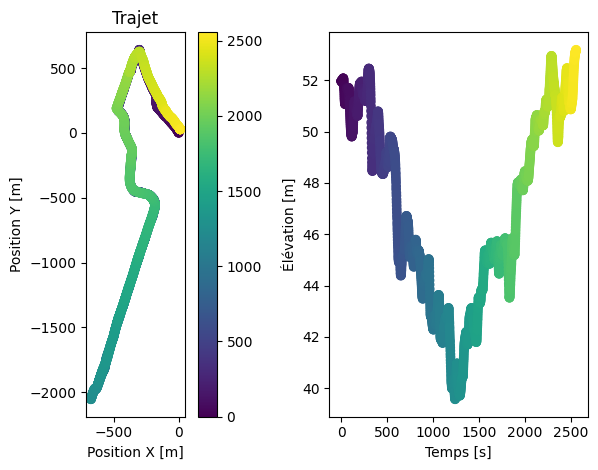

Distance totale: 7.343637327315464 km


In [20]:
# Afficher les données pour vérifier que tout semble correct
fig, axs = plt.subplots(1, 2)
scat = axs[0].scatter(position_x, position_y, c=temps)
axs[0].set_xlabel("Position X [m]")
axs[0].set_ylabel("Position Y [m]")
axs[0].set_title("Trajet")
axs[1].scatter(temps, elevation_montre, c=temps)
# axs[1].plot(temps[1:], distance_parcourue, 'k')
axs[1].set_xlabel("Temps [s]")
axs[1].set_ylabel("Élévation [m]")
fig.colorbar(scat, ax=axs[0], orientation='vertical')
axs[0].set_aspect('equal', 'box')
plt.tight_layout()
plt.show()
print(f"Distance totale: {np.sum(distance_parcourue)/1000} km")

On cherche à obtenir la vitesse de course à partir de la position en utilisant la différence finie.

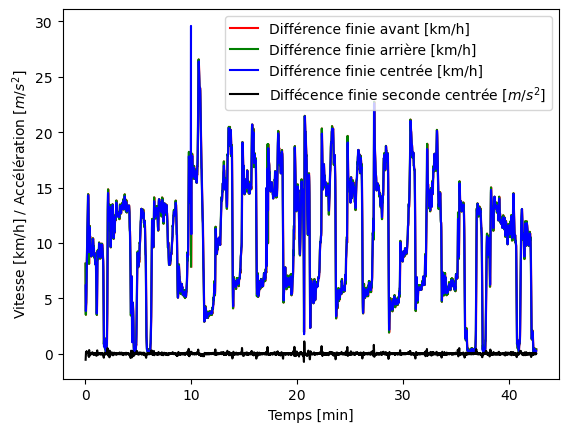

In [28]:
def difference_finie(position_x, position_y, temps):
    
    # Différence finie avant et arrière pour la vitesse
    distance_parcourue = np.linalg.norm(np.array([position_x[1:] - position_x[:-1], position_y[1:] - position_y[:-1]]), axis=0)
    vitesse_1point = distance_parcourue / (temps[1:] - temps[:-1])

    # Différence finie centrée pour la vitesse
    distance_parcourue_2points = np.linalg.norm(np.array([position_x[2:] - position_x[:-2], position_y[2:] - position_y[:-2]]), axis=0)
    vitesse_2points = distance_parcourue_2points / (temps[2:] - temps[:-2])

    # Différence finie pour l'accélération
    acceleration = (distance_parcourue[1:] - distance_parcourue[:-1]) / (temps[2:] - temps[:-2])
    
    return vitesse_1point, vitesse_2points, acceleration

vitesse_1point, vitesse_2points, acceleration = difference_finie(position_x, position_y, temps)

# Afficher les vitesses et accélération
plt.figure()
plt.plot(temps[1:] / 60, vitesse_1point * 3600/1000, 'r', label="Différence finie avant [km/h]")
plt.plot(temps[:-1] / 60, vitesse_1point * 3600/1000, 'g', label="Différence finie arrière [km/h]")
plt.plot(temps[1:-1] / 60, vitesse_2points * 3600/1000, 'b', label="Différence finie centrée [km/h]")
plt.plot(temps[1:-1] / 60, acceleration, 'k', label=r"Diffécence finie seconde centrée [$m/s^2$]")
plt.legend()
plt.xlabel("Temps [min]")
plt.ylabel("Vitesse [km/h] / Accélération [$m/s^2$]")
plt.show()

On voit que le plan d'entraînement a bien été respecté (échauffement, intervalles: 1min marche + 1min course + 30s sprint, cool down). On voit aussi qu'au sein des blocs de marche il y a de la récupération et qu'au sein des blocs de course il y a de la fatigue.
Si on zoom, on voit que la différence finie centrée agit un peu comme un filtre.

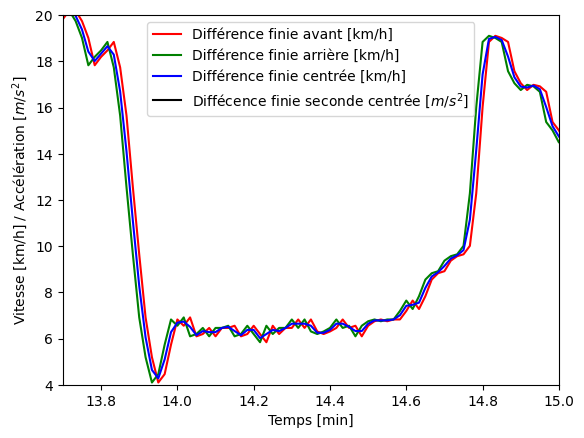

In [30]:
plt.figure()
plt.plot(temps[1:] / 60, vitesse_1point * 3600/1000, 'r', label="Différence finie avant [km/h]")
plt.plot(temps[:-1] / 60, vitesse_1point * 3600/1000, 'g', label="Différence finie arrière [km/h]")
plt.plot(temps[1:-1] / 60, vitesse_2points * 3600/1000, 'b', label="Différence finie centrée [km/h]")
plt.plot(temps[1:-1] / 60, acceleration, 'k', label=r"Diffécence finie seconde centrée [$m/s^2$]")
plt.legend()
plt.xlabel("Temps [min]")
plt.ylabel("Vitesse [km/h] / Accélération [$m/s^2$]")
plt.xlim(13.7, 15)
plt.ylim(4, 20)
plt.show()

On pourrait également préférer filtrer les données d'abbord.

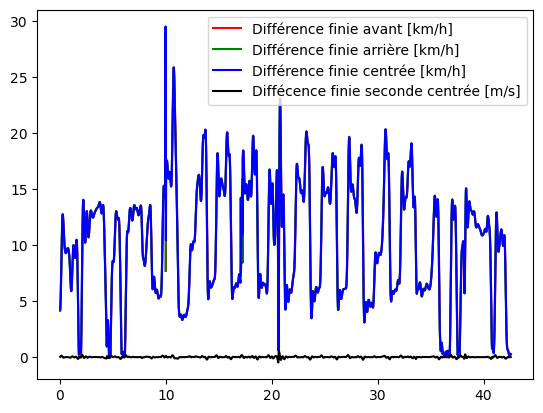

In [31]:
# Filtrer les données avec un filtre passe bas
b, a = butter(8, 0.125, btype='lowpass')
position_x_filtered = filtfilt(b, a, position_x, padlen=150)
position_y_filtered = filtfilt(b, a, position_y, padlen=150)
vitesse_1point_filtered, vitesse_2points_filtered, acceleration_filtered = difference_finie(position_x_filtered, position_y_filtered, temps)

# Afficher les vitesses et accélération filtrées
plt.figure()
plt.plot(temps[1:] / 60, vitesse_1point_filtered * 3600/1000, 'r', label="Différence finie avant [km/h]")
plt.plot(temps[:-1] / 60, vitesse_1point_filtered * 3600/1000, 'g', label="Différence finie arrière [km/h]")
plt.plot(temps[1:-1] / 60, vitesse_2points_filtered * 3600/1000, 'b', label="Différence finie centrée [km/h]")
plt.plot(temps[1:-1] / 60, acceleration_filtered, 'k', label="Diffécence finie seconde centrée [m/s]")
plt.legend()
plt.show()

Utilisons maintenant plutôt la dérivée de polynômes pour obtenir la vitesse.

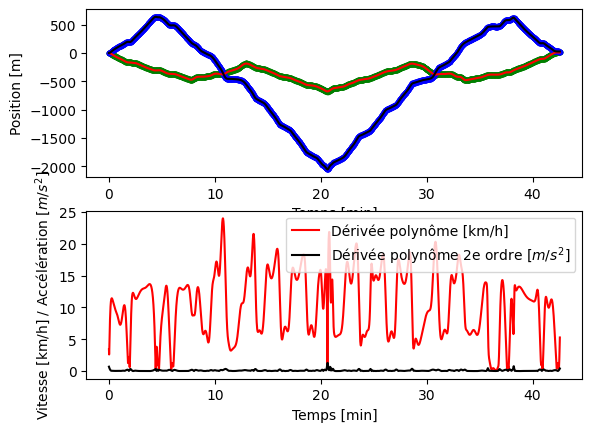

In [24]:
def derivee_polynome(position_x, position_y, temps):
    # Fit spline de degré 5
    spline_x = UnivariateSpline(temps, position_x, k=5)
    spline_y = UnivariateSpline(temps, position_y, k=5)
    # Calculer la dérivée du polynome
    vitesse_x = spline_x.derivative()(temps)
    vitesse_y = spline_y.derivative()(temps)
    vitesse = np.linalg.norm(np.array([vitesse_x, vitesse_y]), axis=0)
    acceleration_x = spline_x.derivative(2)(temps)
    acceleration_y = spline_y.derivative(2)(temps)
    acceleration = np.linalg.norm(np.array([acceleration_x, acceleration_y]), axis=0)
    return vitesse, acceleration, spline_x, spline_y

vitesse, acceleration, spline_x, spline_y = derivee_polynome(position_x, position_y, temps)

# Afficher les vitesses et accélération
fig, axs = plt.subplots(2, 1)
axs[0].plot(temps / 60, position_x, '.g', label="Position X [m]")
axs[0].plot(temps / 60, position_y, '.b', label="Position Y [m]")
axs[0].plot(temps / 60, spline_x(temps), 'r', label="Polynôme X")
axs[0].plot(temps / 60, spline_y(temps), 'k', label="Polynôme Y")
axs[1].plot(temps / 60, vitesse * 3600/1000, 'r', label="Dérivée polynôme [km/h]")
axs[1].plot(temps / 60, acceleration, 'k', label=r"Dérivée polynôme 2e ordre [$m/s^2$]")
axs[1].legend()
axs[0].set_xlabel("Temps [min]")
axs[1].set_xlabel("Temps [min]")
axs[0].set_ylabel("Position [m]")
axs[1].set_ylabel("Vitesse [km/h] / Accélération [$m/s^2$]")
plt.show()

On obtient une vitesse beaucoup plus lisse, mais on s'éloigne des données réelles. Comparons maintenant les méthodes entre elles.

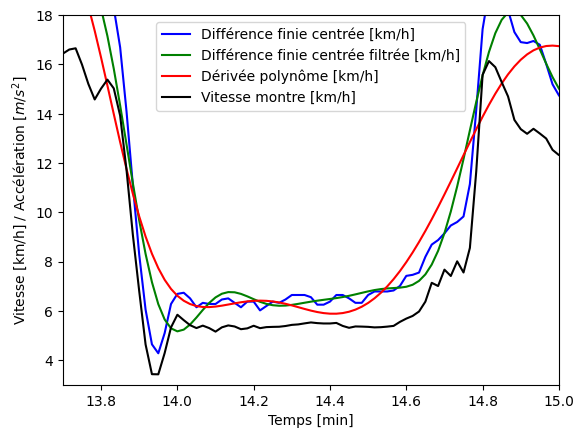

In [32]:
vitesse_montre = dataset['extensions/speed']

plt.figure()
plt.plot(temps[1:-1] / 60, vitesse_2points * 3600/1000, 'b', label="Différence finie centrée [km/h]")
plt.plot(temps[1:-1] / 60, vitesse_2points_filtered * 3600/1000, 'g', label="Différence finie centrée filtrée [km/h]")
plt.plot(temps / 60, vitesse * 3600/1000, 'r', label="Dérivée polynôme [km/h]")
plt.plot(temps / 60, vitesse_montre * 3600/1000, 'k', label="Vitesse montre [km/h]")
plt.legend()
plt.xlabel("Temps [min]")
plt.ylabel("Vitesse [km/h] / Accélération [$m/s^2$]")
plt.xlim(13.7, 15)
plt.ylim(3, 18)
plt.show()

On voit que La différence finie centrée est la plus proche des données réelles, mais que la dérivée de polynôme est beaucoup plus smooth. Il faut donc choisir la méthode approprié en fonction de nos besoins.
Malheureusement, on remarque aussi que notre méthode semble décallée par rapport aux données de la montre.

## Bonus
Ici, on a considéré qu'on pouvait négliger la courbure de la Terre, mais ce n'est pas le cas. Voici la façon de faire pour les intéressés.

In [38]:
def convertir_longitude_latitude_en_distance(latitude, longitude):
    
    # Calculer la distance parcourue entre chaque poin de donnée
    dlat_1point = latitude[1:] - latitude[:-1]
    dlon_1point = longitude[1:] - longitude[:-1]
    
    # Formule de Haversine pour la différence entre deux point consécutifs
    a_1point = np.sin(dlat_1point / 2)**2 + np.cos(latitude[:-1]) * np.cos(latitude[1:]) * np.sin(dlon_1point / 2)**2
    c_1point = 2 * np.arctan2(np.sqrt(a_1point), np.sqrt(1 - a_1point))
    distance_parcourue_1point = R * c_1point
    
    # Formule de Haversine pour la différence entre deux point par bonds de 2
    dlat_2points = latitude[2:] - latitude[:-2]
    dlon_2points = longitude[2:] - longitude[:-2]
    a_2points = np.sin(dlat_2points / 2)**2 + np.cos(latitude[:-2]) * np.cos(latitude[2:]) * np.sin(dlon_2points / 2)**2
    c_2points = 2 * np.arctan2(np.sqrt(a_2points), np.sqrt(1 - a_2points))
    distance_parcourue_2points = R * c_2points
    
    return distance_parcourue_1point, distance_parcourue_2points

distance_parcourue_1point, distance_parcourue_2points = convertir_longitude_latitude_en_distance(latitude, longitude)
vitesse_1point_courbure = distance_parcourue_1point / (temps[1:] - temps[:-1])
vitesse_centree_courbure = distance_parcourue_2points / (temps[2:] - temps[:-2])

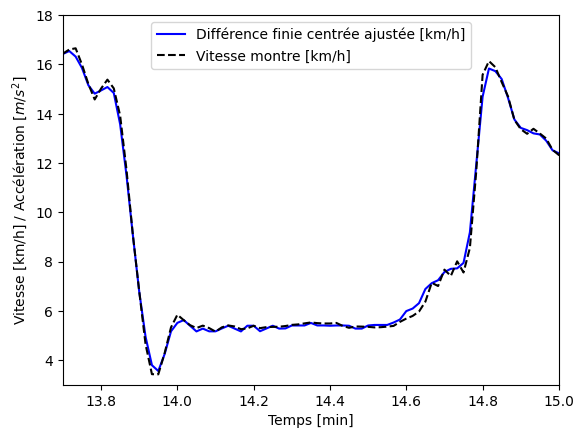

In [43]:
plt.figure()
# plt.plot(temps[1:] / 60, vitesse_1point_courbure * 3600/1000, 'r', label="Différence finie avant ajustée [km/h]")
plt.plot(temps[1:-1] / 60, vitesse_centree_courbure * 3600/1000, 'b', label="Différence finie centrée ajustée [km/h]")
plt.plot(temps / 60, vitesse_montre * 3600/1000, '--k', label="Vitesse montre [km/h]")
plt.legend()
plt.xlabel("Temps [min]")
plt.ylabel("Vitesse [km/h] / Accélération [$m/s^2$]")
plt.xlim(13.7, 15)
plt.ylim(3, 18)
plt.show()